In [1]:
import sys

sys.path.append("../")

from bunkatopics import Bunka
from bunkatopics.functions.clean_text import clean_tweet
from langchain.embeddings import HuggingFaceEmbeddings
import random
from datasets import load_dataset
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
dataset = load_dataset("rguo123/trump_tweets")["train"]
full_docs = dataset["content"]
full_docs = [clean_tweet(x) for x in full_docs]
full_docs = [x for x in full_docs if len(x)>50]
full_docs = random.sample(full_docs, 2000)

In [3]:
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
bunka = Bunka(embedding_model=embedding_model)
bunka.fit(full_docs)

from langchain.llms import OpenAI
open_ai_generative_model = OpenAI(openai_api_key = os.getenv('OPEN_AI_KEY'))

INFO      |2023-11-19 14:59:05|{}|fit|Extracting Terms
/Users/charlesdedampierre/Desktop/bunka_related_projects/BunkaTopics/.venv/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
100%|████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 166.89it/s]
INFO      |2023-11-19 14:59:18|{}|fit|Embedding Documents, this may take few minutes
INFO      |2023-11-19 14:59:24|{}|fit|Reducing Dimensions
/Users/charlesdedampierre/Desktop/bunka_related_projects/BunkaTopics/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting rand

In [ ]:
df_topics = bunka.get_topics(n_clusters=10, min_count_terms=2)

In [13]:
bunka.topics[0]

Topic(topic_id='bt-0', name='obama | isis | gun | crisis | amendment | attack | army general | dishonesty | detail | answers | arms | dollars fighting | desperation | facts | facility', lemma_name=None, x_centroid=5.965317549024309, y_centroid=10.76399552481515, size=35, top_doc_id=None, top_term_id=None)

In [9]:
from pydantic import BaseModel
import typing as t 
from bunkatopics.functions.bourdieu_api import bourdieu_api
from bunkatopics.datamodel import TopicParam, TopicGenParam


class BourdieuQuery(BaseModel):
    x_left_words: t.List[str] = ["war"]
    x_right_words: t.List[str] = ["peace"]
    y_top_words: t.List[str] = ["men"]
    y_bottom_words: t.List[str] = ["women"]
    radius_size: float = 0.5

res = bourdieu_api(
            bunka.embedding_model,
            bunka.docs,
            bunka.terms,
            bourdieu_query = BourdieuQuery(),
            topic_param = TopicParam(n_clusters = 10),
            generative_ai_name=True,
            topic_gen_param= TopicGenParam(generative_model = open_ai_generative_model))

bourdieu_docs = res[0]
bourdieu_topics = res[1]

Creating new labels for clusters: 100%|████████████████████████████████████████| 10/10 [00:04<00:00,  2.31it/s]


In [10]:
from bunkatopics.visualisation.new_bourdieu_visu import visualize_bourdieu

In [11]:
fig = visualize_bourdieu(
    bourdieu_docs,
    bourdieu_topics,
    display_percent=True,
    convex_hull=True,
    clustering=True,
    width=800,
    height=800,
    label_size_ratio_clusters=100,
    label_size_ratio_label=50,
    label_size_ratio_percent=20,
    manual_axis_name = None)

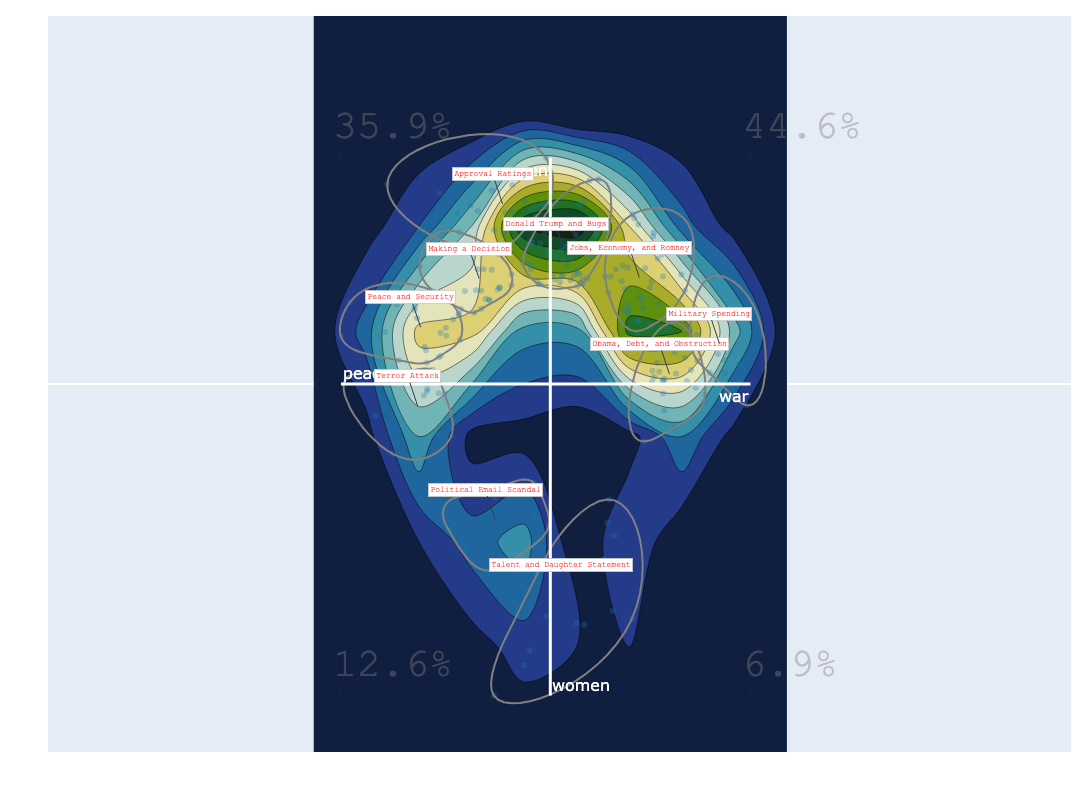

In [12]:
fig

In [12]:
import json


file_path = "bourdieu_docs.json"
bourdieu_docs_json = [x.dict() for x in bourdieu_docs]

with open(file_path, 'w') as json_file:
    json.dump(bourdieu_docs_json, json_file)

   
file_path = "bourdieu_topics.json"
bourdieu_topics_json = [x.dict() for x in bourdieu_topics]
with open(file_path, 'w') as json_file:
    json.dump(bourdieu_topics_json, json_file)
